In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/6. Advanced Applied Maching Learning/Decode_Speech_Project"
%pwd

Mounted at /content/drive
/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/6. Advanced Applied Maching Learning/Decode_Speech_Project


'/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/6. Advanced Applied Maching Learning/Decode_Speech_Project'

In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter

from torch.utils.data import DataLoader

!pip install pynwb
from pynwb import NWBHDF5IO
from custom_dataset import EEG_dataset
from seq2seq_model import EncoderDecoder, Decoder, Encoder
from utils_func import normalize_eeg_features, apply_pca, dutch_number_to_words, clean_and_convert_to_dutch, process_strings
from feature_extraction import hilbert3, extractHG, stackFeatures, downsampleLabels, nameVector, remove_empty_entries

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.2/337.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 34.9 MB/s eta 0:00:00


## Feature extraction from EEG

In [3]:
# Set parameters
winL = 0.025 #0.05
frameshift = 0.01 #0.01
modelOrder = 2
stepSize = 5
path_bids = r'/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/6. Advanced Applied Maching Learning/Decode_Speech_Project'
# r is to prevent \ be treated as escape in string; not necessary here
path_output = r'./features'

# Set the participant ID
participant = 'sub-01'  # Replace with the specific participant ID

# Load data
io = NWBHDF5IO(os.path.join(path_bids,  f'{participant}_task-wordProduction_ieeg.nwb'), 'r')
nwbfile = io.read()

# Extract sEEG data
eeg = nwbfile.acquisition['iEEG'].data[:]
eeg_sr = 1024

# Extract words (markers)
words = nwbfile.acquisition['Stimulus'].data[:]
words = np.array(words, dtype=str)
io.close()

# Load channel information
channels = pd.read_csv(os.path.join(path_bids, f'{participant}_task-wordProduction_channels.tsv'), delimiter='\t')
channels = np.array(channels['name'])

# Remove empty labels
eeg, words = remove_empty_entries(eeg, words)

# Extract High-gamma features
feat = extractHG(eeg, eeg_sr, windowLength=winL, frameshift=frameshift)

# Stack features
feat = stackFeatures(feat, modelOrder=modelOrder, stepSize=stepSize) # timept by chnnl

# Align words to EEG features
words = downsampleLabels(words, eeg_sr, windowLength=winL, frameshift=frameshift)
#words = words[modelOrder*stepSize:words.shape[0]-modelOrder*stepSize] # for numpy words
words = words[modelOrder*stepSize:len(words)-modelOrder*stepSize] # for list words

# Create feature names by appending the temporal shift
feature_names = nameVector(channels[:, None], modelOrder=modelOrder)

print(f"Processing completed for participant: {participant}")

/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


Processing completed for participant: sub-01


# Process words to character and tidy up feature input

In [4]:
# Apply the function get unique words
unique_words = np.unique(words)
converted_words = [clean_and_convert_to_dutch(word) for word in unique_words]
print(converted_words)

# Get min frequency of word to use as the timesteps for a word
word_frequencies = Counter(words)
num_timesteps = min(word_frequencies.values())
print(word_frequencies['helft'], num_timesteps)

['tien', 'twaalf', 'twee', 'drie', 'vijf', 'zes', 'zeven', 'acht', 'negen', 's', 'aan', 'al', 'als', 'bak', 'bakker', 'betovering', 'bevrijd', 'binnenplaats', 'boomstammen', 'braadde', 'dakker', 'dan', 'dat', 'dauwdruppel', 'direct', 'dit', 'donkere', 'door', 'een', 'en', 'er', 'gefluit', 'groen', 'haar', 'helemaal', 'helft', 'hem', 'het', 'hierop', 'hij', 'hoe', 'je', 'juist', 'kasteel', 'kin', 'komt', 'lij', 'maantje', 'maar', 'meisjes', 'met', 'mooi', 'mooie', 'naar', 'nachtegalen', 'niet', 'nog', 'of', 'om', 'onmiddellijk', 'onschuldig', 'ook', 'op', 'over', 'pak', 'redetwisten', 'schold', 'smeekte', 'spreuk', 'sprong', 'sterkste', 'stiekem', 'stilstaan', 'struik', 'te', 'teruggekregen', 'totdat', 'tussen', 'tuwiet', 'vak', 'van', 'veel', 'verdwaald', 'verstijfde', 'vloog', 'vogelkooitje', 'vogeltje', 'wak', 'wanneer', 'was', 'wegpakte', 'wel', 'werd', 'zanddak', 'ze', 'zei', 'zevenduizend', 'zich', 'zijn', 'zo']
189 187


In [5]:
# Convert EEG features into num_words x timept x chnnl
# clean y: convert arabic numbers into dutch strings and remove symbols like '

X = np.zeros([len(unique_words),num_timesteps, feat.shape[1]])
y = []
counter = 0
i = 0
while i < feat.shape[0]:
    key = words[i]
    end_pt = i + num_timesteps

    X[counter,:,:] = feat[i:end_pt,:]
    y.append(key)
    i += word_frequencies[key]

y_cleaned = [clean_and_convert_to_dutch(word) for word in y]

## Convert cleaned y to character level np array

In [6]:
y_char_mat, char_to_int, int_to_char = process_strings(y_cleaned, seq_len=15)

## PCA and normalization of feature

In [8]:
X = apply_pca(X, n_components=200)
X = normalize_eeg_features(X)

## Custom dataset, dataloader

In [7]:
# Split the data into training (90%) and testing (10%) sets
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_char_mat[:train_size], y_char_mat[train_size:]

# Create the dataset
train_dataset = EEG_dataset(X_train, y_train)
test_dataset = EEG_dataset(X_test, y_test)
train_dataset[0]


(tensor([[3.0349, 3.2106, 3.1212,  ..., 2.5547, 2.5208, 2.3516],
         [2.3562, 3.5069, 3.9302,  ..., 2.7675, 2.5926, 3.1158],
         [2.2035, 2.0649, 3.1519,  ..., 2.2421, 1.8901, 3.3427],
         ...,
         [6.2603, 4.7683, 4.1812,  ..., 2.0682, 1.8205, 1.5988],
         [6.7913, 5.1283, 3.8478,  ..., 2.1183, 2.8252, 1.7154],
         [5.2246, 3.6916, 2.2803,  ..., 2.6326, 4.0794, 2.5954]]),
 tensor([10.,  7., 14.,  8., 22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.]))

In [8]:
# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

# Example of iterating through the DataLoader
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch {batch}:")
    print("X shape:", X.shape)
    print("y shape:", y.shape, y.dtype)
    if batch == 2:  # Print only the first 3 batches
        break

print("Number of batches:", len(train_dataloader))

Batch 0:
X shape: torch.Size([2, 187, 635])
y shape: torch.Size([2, 15]) torch.float32
Batch 1:
X shape: torch.Size([2, 187, 635])
y shape: torch.Size([2, 15]) torch.float32
Batch 2:
X shape: torch.Size([2, 187, 635])
y shape: torch.Size([2, 15]) torch.float32
Number of batches: 45


## Train and evaluate

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
# X shape: (num words, eeg seq len, feature size) and y shape: (num words, output char len)
seq_len = 15
input_dim = train_dataloader.dataset[0][0].shape[1]
hidden_dim = 128*4
num_hidden_layers = 4
output_dim = 29  # Vocabulary size

# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# Initialize the model
encoder = Encoder(input_dim, hidden_dim)
decoder = Decoder(hidden_dim, output_dim)
model = EncoderDecoder(encoder, decoder)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, target)
        loss = criterion(output.view(-1, output_dim), target.view(-1).long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data, target)  # Turn off teacher forcing
            loss = criterion(output.view(-1, output_dim), target.view(-1).long())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss:.4f}')


Epoch 1/10, Train Loss: 1.7757
Validation Loss: 1.7235
Epoch 2/10, Train Loss: 1.4510
Validation Loss: 1.8465
Epoch 3/10, Train Loss: 1.5032
Validation Loss: 1.3804
Epoch 4/10, Train Loss: 1.3915
Validation Loss: 1.9219
Epoch 5/10, Train Loss: 1.3771
Validation Loss: 1.8112
Epoch 6/10, Train Loss: 1.3280
Validation Loss: 1.5598
Epoch 7/10, Train Loss: 1.2774
Validation Loss: 1.6031
Epoch 8/10, Train Loss: 1.2367
Validation Loss: 1.8139
Epoch 9/10, Train Loss: 1.2962
Validation Loss: 1.4285
Epoch 10/10, Train Loss: 1.3966
Validation Loss: 1.4962


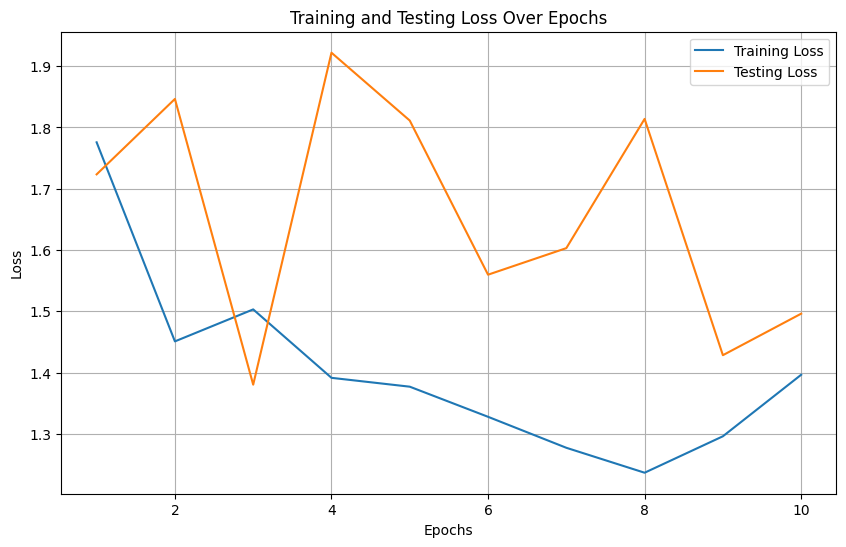

In [11]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Example outcomes

In [17]:
import random

def indices_to_chars(indices):
    return ''.join([int_to_char[idx] for idx in indices if idx in int_to_char])

# Set model to evaluation mode
model.eval()

# Get all samples from the test_dataloader
all_samples = []
for data, target in test_dataloader:
    all_samples.extend(list(zip(data, target)))

# Randomly select 10 samples
random_samples = random.sample(all_samples, 10)

# Process the selected samples
with torch.no_grad():
    for i, (data, target) in enumerate(random_samples):
        data, target = data.unsqueeze(0).to(device), target.unsqueeze(0).to(device)
        output = model(data, target, 0)  # Turn off teacher forcing

        # Get the predicted indices
        _, predicted_indices = torch.max(output, dim=2)

        # Convert predictions and targets to characters
        predicted_chars = indices_to_chars(predicted_indices[0].cpu().numpy())
        target_chars = indices_to_chars(target[0].cpu().numpy())

        print(f"Sample {i + 1}:")
        print(f"Predicted: {predicted_chars}")
        print(f"Target:    {target_chars}")
        print()

Sample 1:
Predicted: bee
Target:    hij

Sample 2:
Predicted: tea
Target:    s

Sample 3:
Predicted: tee
Target:    zo

Sample 4:
Predicted: were
Target:    schold

Sample 5:
Predicted: beeee
Target:    onschuldig

Sample 6:
Predicted: teee
Target:    tussen

Sample 7:
Predicted: ter
Target:    veel

Sample 8:
Predicted: bere
Target:    meisjes

Sample 9:
Predicted: ba
Target:    als

Sample 10:
Predicted: bateeee
Target:    binnenplaats



In [16]:
# Set model to evaluation mode
model.eval()

# Get all samples from the test_dataloader
all_samples = []
for data, target in train_dataloader:
    all_samples.extend(list(zip(data, target)))

# Randomly select 10 samples
random_samples = random.sample(all_samples, 10)

# Process the selected samples
with torch.no_grad():
    for i, (data, target) in enumerate(random_samples):
        data, target = data.unsqueeze(0).to(device), target.unsqueeze(0).to(device)
        output = model(data, target, 0)  # Turn off teacher forcing

        # Get the predicted indices
        _, predicted_indices = torch.max(output, dim=2)

        # Convert predictions and targets to characters
        predicted_chars = indices_to_chars(predicted_indices[0].cpu().numpy())
        target_chars = indices_to_chars(target[0].cpu().numpy())

        print(f"Sample {i + 1}:")
        print(f"Predicted: {predicted_chars}")
        print(f"Target:    {target_chars}")
        print()

Sample 1:
Predicted: teee
Target:    stiekem

Sample 2:
Predicted: teeee
Target:    vogeltje

Sample 3:
Predicted: ber
Target:    hem

Sample 4:
Predicted: teee
Target:    totdat

Sample 5:
Predicted: ter
Target:    wak

Sample 6:
Predicted: teir
Target:    twee

Sample 7:
Predicted: ter
Target:    van

Sample 8:
Predicted: bee
Target:    en

Sample 9:
Predicted: ba
Target:    al

Sample 10:
Predicted: bea
Target:    pak

